<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/language-models/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Build and Train BERT from scratch

In [1]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
text = (
        'Hello, how are you? I am Romeo.\n'
        'Hello, Romeo My name is Juliet. Nice to meet you.\n'
        'Nice meet you too. How are you today?\n'
        'Great. My baseball team won the competition.\n'
        'Oh Congratulations, Juliet\n'
        'Thanks you Romeo'
    )

In [3]:
sentences = re.sub("[.,!?\\-]", '', text.lower()).split('\n')  # filter '.', ',', '?', '!'
word_list = list(set(" ".join(sentences).split()))
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
for i, w in enumerate(word_list):
    word_dict[w] = i + 4
number_dict = {i: w for i, w in enumerate(word_dict)}
vocab_size = len(word_dict)
token_list = list()
for sentence in sentences:
    arr = [word_dict[s] for s in sentence.split()]
    token_list.append(arr)
word_dict

{'[PAD]': 0,
 '[CLS]': 1,
 '[SEP]': 2,
 '[MASK]': 3,
 'congratulations': 4,
 'you': 5,
 'i': 6,
 'how': 7,
 'juliet': 8,
 'nice': 9,
 'are': 10,
 'romeo': 11,
 'is': 12,
 'the': 13,
 'am': 14,
 'meet': 15,
 'name': 16,
 'my': 17,
 'won': 18,
 'too': 19,
 'baseball': 20,
 'hello': 21,
 'to': 22,
 'team': 23,
 'thanks': 24,
 'oh': 25,
 'today': 26,
 'competition': 27,
 'great': 28}

In [4]:
token_list

[[21, 7, 10, 5, 6, 14, 11],
 [21, 11, 17, 16, 12, 8, 9, 22, 15, 5],
 [9, 15, 5, 19, 7, 10, 5, 26],
 [28, 17, 20, 23, 18, 13, 27],
 [25, 4, 8],
 [24, 5, 11]]

In [5]:
maxlen = 30 # maximum of length
batch_size = 5 # batch size
max_pred = 5  # max tokens of prediction
n_layers = 6 # number of Encoder of Encoder Layer
n_heads = 12 # number of heads in Multi-Head Attention
d_model = 768 # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

In [6]:
def make_batch():
    batch = []
    positive = negative = 0
    while positive != batch_size/2 or negative != batch_size/2:
        # randomly generate 2 sentences from length of sentences
        tokens_a_index, tokens_b_index = randrange(len(sentences)), randrange(len(sentences))
        # get the list of tokens for sentence a and b
        tokens_a, tokens_b = token_list[tokens_a_index], token_list[tokens_b_index]
        # create inputs with masked tokens
        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]
        # segments - 0's for all tokens from first sentence, 1's from all tokens from 2nd sentence
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)
        # take min of max tokens and 15% of tokens in one sentence
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15))))
        # non masked tokens
        cand_maked_pos = [i for i, token in enumerate(input_ids)
                          if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]

        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []

        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word_dict[number_dict[index]] # replace

        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # Zero Padding (100% - 15%) tokens
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        # if randomly selected sentences are same
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1

        # if randomly selected sentences are not same
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
        break
    return batch

In [7]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [8]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [9]:
batch = make_batch()
np.shape(batch)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(1, 5)

In [10]:
# converting to tensors
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

In [11]:
masks = get_attn_pad_mask(input_ids, input_ids)

In [12]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        #x -> batchsize, seq_len
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

In [13]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return scores, context, attn

In [14]:
emb = Embedding()
embeds = emb(input_ids, segment_ids)
attenM = get_attn_pad_mask(input_ids, input_ids)
SDPA= ScaledDotProductAttention()(embeds, embeds, embeds, attenM)
scores, context, attention = SDPA
print('Masks',masks[0][0])
print('Scores: ', scores[0][0],'\n\nAttention M: ', attention[0][0])

Masks tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])
Scores:  tensor([ 9.6000e+01,  2.6397e+01,  2.8836e+01,  3.3597e+01,  3.2568e+01,
         2.9256e+01,  3.1573e+01,  3.0402e+01,  2.7135e+01,  3.2370e+01,
        -7.9103e+00, -3.8390e+00,  3.3592e+00,  3.9231e+00,  2.5317e+00,
        -3.3387e-01,  3.0839e+00,  7.9930e-01, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
       grad_fn=<SelectBackward0>) 

Attention M:  tensor([1.0000e+00, 5.9134e-31, 6.7773e-30, 7.9243e-28, 2.8312e-28, 1.0319e-29,
        1.0468e-28, 3.2445e-29, 1.2372e-30, 2.3227e-28, 1.4013e-45, 4.3440e-44,
        5.8444e-41, 1.0271e-40, 2.5550e-41, 1.4545e-42, 4.4379e-41, 4.5192e-42,
        0.0000e+00, 0

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)

    def forward(self, Q, K, V, attn_mask):

        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]
        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores, context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]


In [16]:
emb = Embedding()
embeds = emb(input_ids, segment_ids)
attenM = get_attn_pad_mask(input_ids, input_ids)
print(embeds.shape)
MHA= MultiHeadAttention()(embeds, embeds, embeds, attenM)
Output, A = MHA
A[0][0][0]

torch.Size([1, 30, 768])


tensor([0.0584, 0.0580, 0.0312, 0.0413, 0.0435, 0.0437, 0.0932, 0.0532, 0.0646,
        0.0824, 0.0644, 0.0286, 0.0741, 0.0361, 0.0485, 0.0439, 0.0652, 0.0698,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], grad_fn=<SelectBackward0>)

In [17]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(gelu(self.fc1(x)))


In [18]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [19]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = gelu
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled) # [batch_size, 2]

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf

In [20]:
model = BERT()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

for epoch in range(100):
    optimizer.zero_grad()
    logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    loss_clsf = criterion(logits_clsf, isNext) # for sentence classification
    loss = loss_lm + loss_clsf
    if (epoch + 1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Epoch: 0010 cost = 21.517279
Epoch: 0020 cost = 43.442154
Epoch: 0030 cost = 3.504237
Epoch: 0040 cost = 3.189235
Epoch: 0050 cost = 2.694084
Epoch: 0060 cost = 3.308678
Epoch: 0070 cost = 3.501080
Epoch: 0080 cost = 1.464950
Epoch: 0090 cost = 3.972670
Epoch: 0100 cost = 1.046822


In [21]:
# Predict mask tokens ans isNext
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[0]))
print(input_ids)
print([number_dict[w.item()] for w in input_ids[0] if number_dict[w.item()] != '[PAD]'])
logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
logits_lm = logits_lm.data.max(2)[1][0].data.numpy()
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0] if pos.item() != 0])
print('predict masked tokens list : ',[pos for pos in logits_lm if pos != 0])

logits_clsf = logits_clsf.data.max(1)[1].data.numpy()[0]
print('isNext : ', True if isNext else False)
print('predict isNext : ',True if logits_clsf else False)

tensor([[ 1, 28, 17, 20, 23, 18, 13,  3,  2,  9, 15,  5, 19,  3, 10,  3, 26,  2,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
['[CLS]', 'great', 'my', 'baseball', 'team', 'won', 'the', '[MASK]', '[SEP]', 'nice', 'meet', 'you', 'too', '[MASK]', 'are', '[MASK]', 'today', '[SEP]']
masked tokens list :  [27, 5, 7]
predict masked tokens list :  [27, 7, 7, 7, 7]
isNext :  False
predict isNext :  False


## Fine-tuning BERT models


In [22]:
%%bash
pip install -q datasets
pip install -q transformers
pip install -q sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:00


In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from datasets import load_dataset
from matplotlib import pyplot as plt

# specify GPU
device = torch.device("cuda")
device

device(type='cuda')

In [24]:
data = load_dataset("sms_spam")
data

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

In [25]:
df = pd.DataFrame(data["train"])
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [26]:
df.label.value_counts(normalize=True)

0    0.865985
1    0.134015
Name: label, dtype: float64

In [27]:
# rename columns
df.columns = ["text", "label"]
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [28]:
train_text, test_text, train_labels, test_labels = train_test_split(df.text, df.label, test_size=0.2, random_state=42, stratify=df.label)

In [137]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

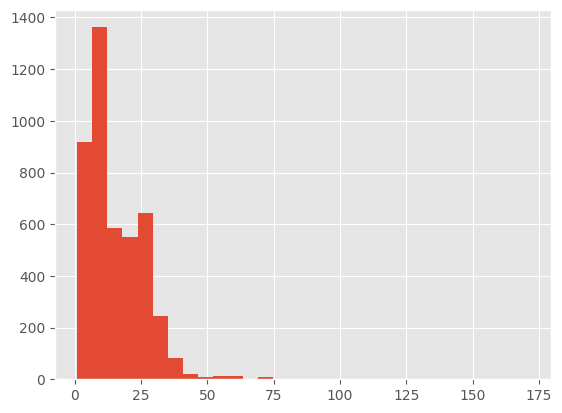

In [138]:
text_lengths = [len(text.split()) for text in train_text]
plt.style.use("ggplot")
plt.hist(text_lengths, bins=30)
plt.show()

In [139]:
tokens_train = tokenizer(train_text.tolist(), padding=True, truncation=True, max_length=25)
tokens_test = tokenizer(test_text.tolist(), padding=True, truncation=True, max_length=25)

In [140]:
tokens_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [141]:
train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
train_y = torch.tensor(train_labels.tolist())

In [142]:
test_seq = torch.tensor(tokens_test["input_ids"])
test_mask = torch.tensor(tokens_test["attention_mask"])
test_y = torch.tensor(test_labels.tolist())

In [143]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = torch.utils.data.SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [144]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [145]:
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BERTClassifier, self).__init__()
        self.model = bert
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512,2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):
        _, out = self.model(input_id, attention_mask=mask, return_dict=False)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [146]:
model = BERTClassifier(bert)
model = model.to(device)
np.unique(train_y.numpy())

array([0, 1])

In [147]:
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight

optimizer = AdamW(model.parameters(), lr=2e-5)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_y.numpy()), y=train_y.numpy())
class_weights

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


array([0.57744108, 3.72826087])

In [148]:
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
cross_entropy = nn.CrossEntropyLoss(weight=class_weights)

In [149]:
def train():
    model.train()
    total_loss = 0
    total_accuracy = 0
    total_preds = []
    for epoch in range(epochs):
        for step, batch in enumerate(train_dataloader):
            batch = [r.to(device) for r in batch]
            sent_id, mask, labels = batch
            model.zero_grad()
            outputs = model(sent_id, mask)
            loss = cross_entropy(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            preds = outputs.detach().cpu().numpy()
            total_preds.append(preds)
    total_preds.append(preds)
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss, np.concatenate(total_preds, axis=0)

In [150]:
def evaluate():
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_preds = []
    for step, batch in enumerate(test_dataloader):
      batch = [t.to(device) for t in batch]
      sent_id, mask, labels = batch
      with torch.no_grad():
        outputs = model(sent_id, mask)
        loss = cross_entropy(outputs, labels)
        total_loss += loss.item()
        preds = outputs.detach().cpu().numpy()
        total_preds.append(preds)
    avg_loss = total_loss / len(test_dataloader)
    return avg_loss, np.concatenate(total_preds, axis=0)

In [151]:
import tqdm
best_loss = float('inf')
epochs = 3
train_losses = []
test_losses = []
for epoch in tqdm.tqdm(range(epochs)):
    train_loss, _ = train()
    test_loss, _ = evaluate()
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'best_model_state.bin')
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch: {epoch+1:02}')
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')
    print('-'*10)

 33%|███▎      | 1/3 [00:31<01:03, 31.56s/it]

Epoch: 01
Train Loss: 1.953
Test Loss: 0.604
----------


 67%|██████▋   | 2/3 [00:58<00:29, 29.12s/it]

Epoch: 02
Train Loss: 1.725
Test Loss: 0.540
----------


100%|██████████| 3/3 [01:25<00:00, 28.65s/it]

Epoch: 03
Train Loss: 1.576
Test Loss: 0.502
----------


In [152]:
model_path = '/content/best_model_state.bin'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [155]:
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       966
           1       0.47      0.82      0.60       149

    accuracy                           0.85      1115
   macro avg       0.72      0.84      0.76      1115
weighted avg       0.90      0.85      0.87      1115

